<a href="https://colab.research.google.com/github/euguroglu/Kaggle/blob/master/Kaggle_Titanic_Survival_Classification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure

Data check and preperation

In [61]:
df = pd.read_csv('train.csv')

In [62]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [63]:
df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

In [64]:
df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [65]:
df = df.drop('Cabin',1)

In [66]:
df = df.drop(['Ticket','Name'],1)

In [67]:
df = df.dropna()

In [68]:
df.set_index('PassengerId',inplace=True)

In [69]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


Data seperation categorial and continous

In [72]:
cat_cols = ['Sex','Embarked','Pclass']
cont_cols = ['Age','SibSp','Parch','Fare']
y_col = ['Survived']

In [73]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [74]:
Sx = df['Sex'].cat.codes.values
Em = df['Embarked'].cat.codes.values
Pc = df['Pclass'].cat.codes.values

cats = np.stack([Sx,Em,Pc], 1)
cats = torch.LongTensor(cats)

In [75]:
cats

tensor([[1, 2, 2],
        [0, 0, 0],
        [0, 2, 2],
        ...,
        [0, 2, 0],
        [1, 0, 0],
        [1, 1, 2]])

In [76]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.FloatTensor(conts)
conts[:5]

tensor([[22.0000,  1.0000,  0.0000,  7.2500],
        [38.0000,  1.0000,  0.0000, 71.2833],
        [26.0000,  0.0000,  0.0000,  7.9250],
        [35.0000,  1.0000,  0.0000, 53.1000],
        [35.0000,  0.0000,  0.0000,  8.0500]])

In [77]:
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 1, 1, 1, 0])

Data preperation for embedding

In [78]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (3, 2), (3, 2)]

In [79]:
cat_szs 

[2, 3, 3]

Neural Network

In [80]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.4):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [81]:
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

Model summary

In [82]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 2)
    (2): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

Cost function and optimization

In [83]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss performs better for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [84]:
cat_train = cats
con_train = conts
y_train = y

Training

In [85]:
import time
start_time = time.time()

epochs = 3000
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
  
    # a neat trick to save screen space:
    if i%10 == 1:
        print('Epoch: {} and Loss: {:8.4f}'.format(i,loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch: 1 and Loss:   0.8743
Epoch: 11 and Loss:   0.6420
Epoch: 21 and Loss:   0.5968
Epoch: 31 and Loss:   0.5873
Epoch: 41 and Loss:   0.5493
Epoch: 51 and Loss:   0.5852
Epoch: 61 and Loss:   0.5459
Epoch: 71 and Loss:   0.5494
Epoch: 81 and Loss:   0.5580
Epoch: 91 and Loss:   0.5612
Epoch: 101 and Loss:   0.5460
Epoch: 111 and Loss:   0.5314
Epoch: 121 and Loss:   0.5295
Epoch: 131 and Loss:   0.5101
Epoch: 141 and Loss:   0.5108
Epoch: 151 and Loss:   0.5121
Epoch: 161 and Loss:   0.5223
Epoch: 171 and Loss:   0.4979
Epoch: 181 and Loss:   0.4967
Epoch: 191 and Loss:   0.5001
Epoch: 201 and Loss:   0.5024
Epoch: 211 and Loss:   0.5045
Epoch: 221 and Loss:   0.4940
Epoch: 231 and Loss:   0.4746
Epoch: 241 and Loss:   0.4840
Epoch: 251 and Loss:   0.4968
Epoch: 261 and Loss:   0.5004
Epoch: 271 and Loss:   0.5043
Epoch: 281 and Loss:   0.4593
Epoch: 291 and Loss:   0.4840
Epoch: 301 and Loss:   0.4782
Epoch: 311 and Loss:   0.5040
Epoch: 321 and Loss:   0.4669
Epoch: 331 and Loss: 

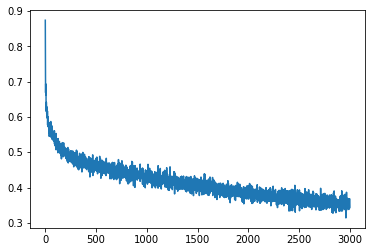

In [86]:
plt.plot(range(epochs),losses)

Prediction

In [87]:
df2 = pd.read_csv('test.csv')

In [88]:
df2

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [89]:
df2.set_index('PassengerId',inplace=True)

In [90]:
df2.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


892

In [92]:
 df2.fillna(df2.mean(),inplace=True)

In [ ]:
df2['SibSp'].unique()

In [101]:
len(df2)

418

In [93]:
cat_cols = ['Sex','Embarked','Pclass']
cont_cols = ['Age','SibSp','Parch','Fare']
y_col = ['Survived']

In [94]:
for cat in cat_cols:
    df2[cat] = df2[cat].astype('category')

In [95]:
Sx = df2['Sex'].cat.codes.values
Em = df2['Embarked'].cat.codes.values
Pc = df2['Pclass'].cat.codes.values

cats_t = np.stack([Sx,Em,Pc], 1)
cats_t = torch.LongTensor(cats)

In [96]:
conts_t = np.stack([df2[col].values for col in cont_cols], 1)
conts_t = torch.FloatTensor(conts)

In [99]:
cat_test = cats_t
con_test = conts_t


In [112]:
with torch.no_grad():
    y_val = model(cat_test,con_test)
    
    

In [ ]:
Surviverlist = []
for i in range(418):
  Surviverlist.append([df2.index[i],y_val[i].argmax().numpy()])

    
  print('{}.) Predicted:: {:8.2f}'.format(df2.index[i],y_val[i].argmax().numpy()))

In [154]:
Surviverlist

[[892, array(0)],
 [893, array(1)],
 [894, array(0)],
 [895, array(0)],
 [896, array(0)],
 [897, array(0)],
 [898, array(0)],
 [899, array(1)],
 [900, array(1)],
 [901, array(1)],
 [902, array(1)],
 [903, array(0)],
 [904, array(0)],
 [905, array(0)],
 [906, array(1)],
 [907, array(0)],
 [908, array(0)],
 [909, array(0)],
 [910, array(0)],
 [911, array(1)],
 [912, array(1)],
 [913, array(0)],
 [914, array(0)],
 [915, array(0)],
 [916, array(0)],
 [917, array(1)],
 [918, array(1)],
 [919, array(1)],
 [920, array(0)],
 [921, array(0)],
 [922, array(1)],
 [923, array(0)],
 [924, array(0)],
 [925, array(1)],
 [926, array(0)],
 [927, array(0)],
 [928, array(0)],
 [929, array(0)],
 [930, array(1)],
 [931, array(1)],
 [932, array(0)],
 [933, array(0)],
 [934, array(0)],
 [935, array(1)],
 [936, array(0)],
 [937, array(0)],
 [938, array(0)],
 [939, array(0)],
 [940, array(1)],
 [941, array(0)],
 [942, array(1)],
 [943, array(0)],
 [944, array(0)],
 [945, array(0)],
 [946, array(0)],
 [947, arr

In [156]:
df3 = pd.DataFrame(Surviverlist)

In [159]:
df3.to_excel(r'C:\sample_data\submission.xlsx', index = False)